# Summary
- mincorr and minlinreg are similar. maxcorr and maxlinreg are similar. 
- spearman among different layers is lower (even goes negative) in lower layers for:
    - bert_large
    - openai
    - bert_base
  
  but not true for elmo or calypso
- intermediate layers appear most similar to the next and previous layer of the same model
- lower layers (eg. in bert) are more correlated with lower layers in other models

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns

In [2]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results8_"
res_fname = {method : base + method for method in 
                {"maxcorr", "mincorr", "maxlinreg", "minlinreg", "cca", "lincka"}}

res_d = {}
res_d["maxcorr"] = json.load(open(res_fname["maxcorr"], "r"))
res_d["mincorr"] = json.load(open(res_fname["mincorr"], "r"))
res_d["maxlinreg"] = json.load(open(res_fname["maxlinreg"], "r"))
res_d["minlinreg"] = json.load(open(res_fname["minlinreg"], "r"))

network_l = [network for network in res_d["maxcorr"]]

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(res_d["maxcorr"][network])

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [3]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [4]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = [neuron[0] for neuron in res_d[method][network]]

In [5]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [6]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_large_cased_0
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.176797   0.841917 -0.265457
maxlinreg  0.176797   1.000000   0.267656  0.648580
minlinreg  0.841917   0.267656   1.000000 -0.205201
maxcorr   -0.265457   0.648580  -0.205201  1.000000
bert_large_cased_1
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.035103   0.744525 -0.017512
maxlinreg  0.035103   1.000000   0.278610  0.966639
minlinreg  0.744525   0.278610   1.000000  0.215490
maxcorr   -0.017512   0.966639   0.215490  1.000000
bert_large_cased_2
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.131480   0.739880  0.115634
maxlinreg  0.131480   1.000000   0.452293  0.977871
minlinreg  0.739880   0.452293   1.000000  0.435666
maxcorr    0.115634   0.977871   0.435666  1.000000
bert_large_cased_3
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.121375   0.799138  0.098167
maxlinreg  0.121375   1.000000   0.37661

            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.520807   0.811357  0.490462
maxlinreg  0.520807   1.000000   0.749236  0.943028
minlinreg  0.811357   0.749236   1.000000  0.735096
maxcorr    0.490462   0.943028   0.735096  1.000000
xlnet_large_cased_21
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.521602   0.817193  0.415716
maxlinreg  0.521602   1.000000   0.723367  0.887033
minlinreg  0.817193   0.723367   1.000000  0.633663
maxcorr    0.415716   0.887033   0.633663  1.000000
xlnet_large_cased_22
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.504240   0.828760  0.335521
maxlinreg  0.504240   1.000000   0.682169  0.758273
minlinreg  0.828760   0.682169   1.000000  0.500716
maxcorr    0.335521   0.758273   0.500716  1.000000
xlnet_large_cased_23
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.424558   0.803794  0.309494
maxlinreg  0.424558   1.000000   0.614470  0.704952
m

### Distributions

In [7]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        corr_ar = np.stack([
            list(notated_neuron[1].values())
            for notated_neuron in res_d[method][network]
        ])
        corr_df = pd.DataFrame(np.abs(corr_ar),
                              columns=[net for net in network_l if net != network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_large_cased_0:

mincorr

maxcounts
bert_large_cased_1                  981
bert_base_cased_0                    40
calypso_transformer_6_512_base_0      2
openai_transformer_2                  1
dtype: int64

mincounts
xlnet_large_cased_23    687
elmo_4x4096_512_2        67
xlnet_large_cased_20     50
xlnet_large_cased_22     34
xlnet_large_cased_16     32
xlnet_large_cased_19     26
xlnet_large_cased_21     20
xlnet_large_cased_18     19
xlnet_large_cased_17     19
xlnet_large_cased_15     18
elmo_4x4096_512_3         9
xlnet_large_cased_13      9
xlnet_large_cased_14      4
xlnet_large_cased_12      3
bert_base_cased_8         3
xlnet_large_cased_1       2
bert_large_cased_19       2
xlnet_large_cased_7       2
xlnet_large_cased_3       2
elmo_4x4096_512_4         2
xlnet_large_cased_9       2
bert_large_cased_18       2
bert_base_cased_12        2
elmo_4x4096_512_1         1
xlnet_large_cased_5       1
elmo_original_2           1
bert_large_cased_21       1
xlnet_large_cased_

          max       min       med
max  1.000000  0.376619  0.679203
min  0.376619  1.000000  0.875231
med  0.679203  0.875231  1.000000

maxcorr

maxcounts
bert_large_cased_2    955
bert_large_cased_4     69
dtype: int64

mincounts
xlnet_large_cased_23                574
xlnet_large_cased_22                 65
xlnet_large_cased_20                 48
elmo_4x4096_512_2                    43
xlnet_large_cased_15                 31
xlnet_large_cased_21                 30
xlnet_large_cased_16                 29
elmo_4x4096_512_3                    27
xlnet_large_cased_19                 26
xlnet_large_cased_13                 24
xlnet_large_cased_18                 21
xlnet_large_cased_14                 18
xlnet_large_cased_17                 14
xlnet_large_cased_12                  8
elmo_4x4096_512_4                     6
xlnet_large_cased_11                  5
xlnet_large_cased_8                   4
calypso_transformer_6_512_base_6      4
elmo_4x4096_512_0                     4
bert_bas


maxcounts
bert_large_cased_6    703
bert_large_cased_4    321
dtype: int64

mincounts
xlnet_large_cased_23                591
xlnet_large_cased_22                 49
elmo_4x4096_512_2                    47
xlnet_large_cased_20                 37
xlnet_large_cased_16                 34
xlnet_large_cased_15                 31
xlnet_large_cased_19                 26
xlnet_large_cased_14                 20
elmo_4x4096_512_3                    20
xlnet_large_cased_18                 18
xlnet_large_cased_17                 18
xlnet_large_cased_13                 17
elmo_4x4096_512_4                    13
xlnet_large_cased_21                 13
xlnet_large_cased_12                 10
elmo_4x4096_512_0                     9
elmo_original_2                       7
openai_transformer_12                 7
bert_base_cased_11                    4
bert_base_cased_12                    4
bert_large_cased_24                   4
openai_transformer_0                  4
xlnet_large_cased_11             

xlnet_large_cased_23                640
elmo_4x4096_512_2                    44
xlnet_large_cased_22                 38
elmo_4x4096_512_3                    34
xlnet_large_cased_15                 26
xlnet_large_cased_20                 26
xlnet_large_cased_16                 23
xlnet_large_cased_19                 20
xlnet_large_cased_21                 18
xlnet_large_cased_17                 16
xlnet_large_cased_14                 14
xlnet_large_cased_13                 11
elmo_original_0                      10
openai_transformer_0                 10
elmo_original_2                      10
xlnet_large_cased_18                  9
elmo_4x4096_512_4                     9
calypso_transformer_6_512_base_6      7
elmo_4x4096_512_0                     6
xlnet_large_cased_10                  5
xlnet_large_cased_1                   5
bert_base_cased_12                    5
openai_transformer_12                 4
xlnet_large_cased_0                   4
openai_transformer_11                 4



maxcounts
bert_large_cased_9     973
bert_large_cased_11     51
dtype: int64

mincounts
xlnet_large_cased_23                580
elmo_4x4096_512_3                    43
elmo_4x4096_512_2                    42
xlnet_large_cased_22                 32
xlnet_large_cased_16                 29
xlnet_large_cased_20                 29
xlnet_large_cased_19                 20
xlnet_large_cased_18                 19
xlnet_large_cased_15                 18
openai_transformer_12                18
elmo_4x4096_512_0                    17
elmo_original_0                      16
xlnet_large_cased_13                 15
xlnet_large_cased_17                 13
xlnet_large_cased_14                 12
xlnet_large_cased_21                 12
elmo_4x4096_512_4                    11
elmo_original_2                      11
xlnet_large_cased_1                  10
openai_transformer_1                  9
calypso_transformer_6_512_base_6      8
openai_transformer_0                  7
openai_transformer_11          


maxcounts
bert_large_cased_11                 822
bert_large_cased_13                 201
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                620
xlnet_large_cased_22                 53
elmo_4x4096_512_2                    36
xlnet_large_cased_20                 26
elmo_4x4096_512_3                    24
openai_transformer_12                19
xlnet_large_cased_19                 18
elmo_4x4096_512_0                    16
xlnet_large_cased_16                 15
xlnet_large_cased_18                 14
elmo_original_0                      13
xlnet_large_cased_17                 13
openai_transformer_0                 13
xlnet_large_cased_15                 11
openai_transformer_1                 11
xlnet_large_cased_21                 10
xlnet_large_cased_2                  10
elmo_original_2                       9
xlnet_large_cased_1                   9
xlnet_large_cased_14                  8
elmo_4x4096_512_4                     7
xlnet

bert_large_cased_13                 839
bert_large_cased_15                 184
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                650
elmo_original_0                      32
elmo_4x4096_512_0                    31
xlnet_large_cased_22                 27
elmo_4x4096_512_3                    26
openai_transformer_0                 26
xlnet_large_cased_1                  24
elmo_4x4096_512_2                    21
openai_transformer_1                 15
xlnet_large_cased_21                 15
xlnet_large_cased_20                 13
xlnet_large_cased_19                 11
openai_transformer_12                10
xlnet_large_cased_16                  9
xlnet_large_cased_18                  9
xlnet_large_cased_15                  9
xlnet_large_cased_13                  8
xlnet_large_cased_2                   8
elmo_original_2                       7
bert_base_cased_12                    7
xlnet_large_cased_17                  6
openai_transform

          max       min       med
max  1.000000  0.540294  0.580178
min  0.540294  1.000000  0.854117
med  0.580178  0.854117  1.000000

maxlinreg

maxcounts
bert_large_cased_17    768
bert_large_cased_15    256
dtype: int64

mincounts
elmo_4x4096_512_0                   512
calypso_transformer_6_512_base_0    160
openai_transformer_12               153
elmo_original_0                     144
openai_transformer_0                 32
xlnet_large_cased_0                  14
xlnet_large_cased_23                  7
bert_base_cased_0                     2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.862016  0.903420
min  0.862016  1.000000  0.943259
med  0.903420  0.943259  1.000000

minlinreg

maxcounts
bert_large_cased_17    768
bert_large_cased_15    256
dtype: int64

mincounts
elmo_4x4096_512_0                   512
calypso_transformer_6_512_base_0    160
openai_transformer_12               153
elmo_original_0                     144
openai_transformer_0 


maxcounts
bert_large_cased_19    1022
bert_large_cased_17       2
dtype: int64

mincounts
elmo_4x4096_512_0                   624
calypso_transformer_6_512_base_0    132
elmo_original_0                     126
openai_transformer_12                99
openai_transformer_0                 32
xlnet_large_cased_23                  6
xlnet_large_cased_0                   4
bert_base_cased_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.840071  0.881180
min  0.840071  1.000000  0.935872
med  0.881180  0.935872  1.000000

minlinreg

maxcounts
bert_large_cased_19    1022
bert_large_cased_17       2
dtype: int64

mincounts
elmo_4x4096_512_0                   624
calypso_transformer_6_512_base_0    132
elmo_original_0                     126
openai_transformer_12                99
openai_transformer_0                 32
xlnet_large_cased_23                  6
xlnet_large_cased_0                   4
bert_base_cased_0                     1
dtyp

elmo_4x4096_512_0                   631
openai_transformer_12               118
calypso_transformer_6_512_base_0    109
elmo_original_0                     101
openai_transformer_0                 56
xlnet_large_cased_23                  5
xlnet_large_cased_0                   2
bert_base_cased_0                     1
openai_transformer_1                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.781412  0.840152
min  0.781412  1.000000  0.932537
med  0.840152  0.932537  1.000000

minlinreg

maxcounts
bert_large_cased_19    991
bert_large_cased_21     33
dtype: int64

mincounts
elmo_4x4096_512_0                   631
openai_transformer_12               118
calypso_transformer_6_512_base_0    109
elmo_original_0                     101
openai_transformer_0                 56
xlnet_large_cased_23                  5
xlnet_large_cased_0                   2
bert_base_cased_0                     1
openai_transformer_1                  1
dtype: int64

cor

bert_large_cased_23    1020
bert_large_cased_21       4
dtype: int64

mincounts
elmo_4x4096_512_0                   540
openai_transformer_12               167
elmo_original_0                     148
calypso_transformer_6_512_base_0    117
openai_transformer_0                 45
xlnet_large_cased_23                  5
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.749303  0.844573
min  0.749303  1.000000  0.923708
med  0.844573  0.923708  1.000000

minlinreg

maxcounts
bert_large_cased_23    1020
bert_large_cased_21       4
dtype: int64

mincounts
elmo_4x4096_512_0                   540
openai_transformer_12               167
elmo_original_0                     148
calypso_transformer_6_512_base_0    117
openai_transformer_0                 45
xlnet_large_cased_23                  5
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.749303  0.844573


          max       min       med
max  1.000000  0.726249  0.765543
min  0.726249  1.000000  0.959710
med  0.765543  0.959710  1.000000

minlinreg

maxcounts
bert_large_cased_23    1024
dtype: int64

mincounts
elmo_4x4096_512_0                   485
openai_transformer_12               246
elmo_original_0                     143
xlnet_large_cased_23                 73
calypso_transformer_6_512_base_0     29
xlnet_large_cased_0                  24
openai_transformer_0                 24
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.726249  0.765543
min  0.726249  1.000000  0.959710
med  0.765543  0.959710  1.000000

maxcorr

maxcounts
bert_large_cased_23     1016
openai_transformer_6       3
bert_large_cased_21        2
xlnet_large_cased_0        1
openai_transformer_4       1
bert_large_cased_22        1
dtype: int64

mincounts
xlnet_large_cased_23                526
elmo_4x4096_512_2                    51
xlnet_large_cased_1                  34
bert_larg


maxcounts
openai_transformer_2    711
openai_transformer_0     53
openai_transformer_6      1
openai_transformer_3      1
openai_transformer_8      1
openai_transformer_7      1
dtype: int64

mincounts
xlnet_large_cased_23                368
elmo_4x4096_512_2                    65
elmo_4x4096_512_3                    43
xlnet_large_cased_22                 35
bert_base_cased_12                   24
xlnet_large_cased_20                 22
xlnet_large_cased_18                 17
elmo_4x4096_512_4                    15
xlnet_large_cased_21                 14
xlnet_large_cased_16                 14
elmo_original_2                      13
xlnet_large_cased_15                 13
bert_large_cased_24                  13
xlnet_large_cased_19                 10
bert_large_cased_23                   9
xlnet_large_cased_13                  8
bert_large_cased_21                   8
bert_base_cased_11                    7
xlnet_large_cased_17                  7
xlnet_large_cased_14                 

          max       min       med
max  1.000000  0.664002  0.723407
min  0.664002  1.000000  0.920776
med  0.723407  0.920776  1.000000

maxlinreg

maxcounts
openai_transformer_5    762
openai_transformer_3      5
openai_transformer_6      1
dtype: int64

mincounts
xlnet_large_cased_23                754
elmo_4x4096_512_0                     7
calypso_transformer_6_512_base_0      6
elmo_original_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.893629  0.946177
min  0.893629  1.000000  0.971187
med  0.946177  0.971187  1.000000

minlinreg

maxcounts
openai_transformer_5    762
openai_transformer_3      5
openai_transformer_6      1
dtype: int64

mincounts
xlnet_large_cased_23                754
elmo_4x4096_512_0                     7
calypso_transformer_6_512_base_0      6
elmo_original_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.893629  0.946177
min  0.893629  1.000000  0

xlnet_large_cased_23                443
calypso_transformer_6_512_base_0    181
elmo_4x4096_512_0                    96
elmo_original_0                      43
bert_base_cased_0                     3
xlnet_large_cased_0                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.943631  0.969724
min  0.943631  1.000000  0.977448
med  0.969724  0.977448  1.000000

maxcorr

maxcounts
openai_transformer_5    592
openai_transformer_7    176
dtype: int64

mincounts
xlnet_large_cased_23                411
bert_large_cased_24                  43
bert_base_cased_12                   31
xlnet_large_cased_22                 30
elmo_4x4096_512_2                    26
elmo_4x4096_512_3                    26
xlnet_large_cased_15                 19
bert_large_cased_23                  14
xlnet_large_cased_21                 11
elmo_original_0                      11
xlnet_large_cased_13                 10
xlnet_large_cased_18                  9
bert_large_cased_

          max       min       med
max  1.000000  0.655736  0.627382
min  0.655736  1.000000  0.899894
med  0.627382  0.899894  1.000000

maxlinreg

maxcounts
openai_transformer_10    536
openai_transformer_8     232
dtype: int64

mincounts
calypso_transformer_6_512_base_0    263
elmo_4x4096_512_0                   260
xlnet_large_cased_23                166
elmo_original_0                      69
bert_base_cased_0                     6
xlnet_large_cased_0                   3
openai_transformer_0                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.921914  0.946399
min  0.921914  1.000000  0.963249
med  0.946399  0.963249  1.000000

minlinreg

maxcounts
openai_transformer_10    536
openai_transformer_8     232
dtype: int64

mincounts
calypso_transformer_6_512_base_0    263
elmo_4x4096_512_0                   260
xlnet_large_cased_23                166
elmo_original_0                      69
bert_base_cased_0                     6
xlnet_large_c

openai_transformer_12    461
openai_transformer_10    307
dtype: int64

mincounts
elmo_4x4096_512_0                   285
elmo_original_0                     204
calypso_transformer_6_512_base_0    196
xlnet_large_cased_23                 68
bert_base_cased_0                     8
xlnet_large_cased_0                   4
openai_transformer_0                  3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.815676  0.888912
min  0.815676  1.000000  0.939532
med  0.888912  0.939532  1.000000

maxcorr

maxcounts
openai_transformer_10    429
openai_transformer_12    339
dtype: int64

mincounts
xlnet_large_cased_23    361
elmo_original_0          38
xlnet_large_cased_1      25
bert_large_cased_23      20
bert_large_cased_24      20
elmo_4x4096_512_0        17
xlnet_large_cased_19     16
bert_base_cased_12       14
xlnet_large_cased_22     12
xlnet_large_cased_2      12
bert_large_cased_21      11
bert_large_cased_2       11
xlnet_large_cased_16     11
bert_larg


maxcounts
bert_base_cased_0     444
bert_base_cased_2     323
bert_large_cased_1      1
dtype: int64

mincounts
xlnet_large_cased_23                468
elmo_4x4096_512_2                    40
xlnet_large_cased_22                 28
xlnet_large_cased_20                 24
xlnet_large_cased_15                 23
xlnet_large_cased_21                 18
xlnet_large_cased_16                 17
xlnet_large_cased_18                 17
elmo_4x4096_512_3                    16
xlnet_large_cased_14                 15
xlnet_large_cased_17                 14
xlnet_large_cased_19                 13
xlnet_large_cased_13                  9
xlnet_large_cased_12                  5
elmo_4x4096_512_4                     5
xlnet_large_cased_7                   4
xlnet_large_cased_9                   4
xlnet_large_cased_11                  4
elmo_4x4096_512_1                     4
elmo_4x4096_512_0                     3
bert_large_cased_21                   3
xlnet_large_cased_6                   3
elmo_or

          max       min       med
max  1.000000  0.509827  0.686491
min  0.509827  1.000000  0.919435
med  0.686491  0.919435  1.000000

minlinreg

maxcounts
bert_base_cased_4    767
bert_base_cased_2      1
dtype: int64

mincounts
xlnet_large_cased_23                628
openai_transformer_12               106
elmo_4x4096_512_0                    22
elmo_original_0                       6
calypso_transformer_6_512_base_0      6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.509827  0.686491
min  0.509827  1.000000  0.919435
med  0.686491  0.919435  1.000000

maxcorr

maxcounts
bert_base_cased_4    595
bert_base_cased_2    173
dtype: int64

mincounts
xlnet_large_cased_23                466
xlnet_large_cased_22                 34
elmo_4x4096_512_2                    34
xlnet_large_cased_20                 26
xlnet_large_cased_16                 25
xlnet_large_cased_15                 25
xlnet_large_cased_21                 22
xlnet_large_cased_18           

          max       min       med
max  1.000000  0.365803  0.447845
min  0.365803  1.000000  0.812698
med  0.447845  0.812698  1.000000


bert_base_cased_6:

mincorr

maxcounts
bert_base_cased_5    583
bert_base_cased_7    185
dtype: int64

mincounts
xlnet_large_cased_23                508
elmo_4x4096_512_2                    27
xlnet_large_cased_22                 26
elmo_4x4096_512_3                    24
elmo_original_0                      13
xlnet_large_cased_21                 12
xlnet_large_cased_19                 12
elmo_4x4096_512_0                    11
openai_transformer_0                 11
xlnet_large_cased_1                  10
xlnet_large_cased_16                 10
xlnet_large_cased_20                 10
xlnet_large_cased_15                 10
openai_transformer_1                  8
openai_transformer_12                 6
elmo_original_2                       5
xlnet_large_cased_17                  5
xlnet_large_cased_18                  5
bert_large_cased_22          

elmo_4x4096_512_0                   451
elmo_original_0                     112
openai_transformer_12                82
calypso_transformer_6_512_base_0     69
xlnet_large_cased_23                 24
openai_transformer_0                 23
xlnet_large_cased_0                   7
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.790125  0.837427
min  0.790125  1.000000  0.913301
med  0.837427  0.913301  1.000000

minlinreg

maxcounts
bert_base_cased_9    758
bert_base_cased_7     10
dtype: int64

mincounts
elmo_4x4096_512_0                   451
elmo_original_0                     112
openai_transformer_12                82
calypso_transformer_6_512_base_0     69
xlnet_large_cased_23                 24
openai_transformer_0                 23
xlnet_large_cased_0                   7
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.790125  0.837427
min  0.790125  1.000000  0.913301
med  0.837427  0.913301  1.000000

maxcorr

maxcount


maxcounts
bert_base_cased_11    765
bert_base_cased_9       3
dtype: int64

mincounts
xlnet_large_cased_23                305
elmo_4x4096_512_0                    55
elmo_original_0                      55
openai_transformer_0                 48
elmo_4x4096_512_2                    39
elmo_4x4096_512_3                    36
xlnet_large_cased_1                  34
openai_transformer_1                 23
xlnet_large_cased_2                  20
xlnet_large_cased_22                 11
bert_large_cased_2                    9
xlnet_large_cased_21                  9
xlnet_large_cased_16                  8
xlnet_large_cased_3                   8
xlnet_large_cased_15                  7
xlnet_large_cased_0                   7
openai_transformer_12                 6
xlnet_large_cased_19                  6
bert_large_cased_0                    6
bert_large_cased_4                    6
bert_large_cased_3                    5
xlnet_large_cased_17                  5
openai_transformer_6             

          max       min       med
max  1.000000  0.760739  0.875874
min  0.760739  1.000000  0.845511
med  0.875874  0.845511  1.000000

maxlinreg

maxcounts
xlnet_large_cased_0                 430
xlnet_large_cased_1                 268
calypso_transformer_6_512_base_1    204
bert_large_cased_0                  118
xlnet_large_cased_2                   4
dtype: int64

mincounts
xlnet_large_cased_23     1016
openai_transformer_12       8
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.822897  0.875107
min  0.822897  1.000000  0.921930
med  0.875107  0.921930  1.000000

minlinreg

maxcounts
xlnet_large_cased_0                 430
xlnet_large_cased_1                 268
calypso_transformer_6_512_base_1    204
bert_large_cased_0                  118
xlnet_large_cased_2                   4
dtype: int64

mincounts
xlnet_large_cased_23     1016
openai_transformer_12       8
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.822897  0.8


maxcounts
elmo_original_1      878
elmo_4x4096_512_4    146
dtype: int64

mincounts
openai_transformer_0                468
elmo_4x4096_512_0                   332
openai_transformer_12               128
calypso_transformer_6_512_base_0     38
xlnet_large_cased_23                 23
openai_transformer_1                 13
elmo_original_0                       8
xlnet_large_cased_0                   7
bert_base_cased_0                     6
openai_transformer_5                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.824728  0.955226
min  0.824728  1.000000  0.906927
med  0.955226  0.906927  1.000000

minlinreg

maxcounts
elmo_original_1      878
elmo_4x4096_512_4    146
dtype: int64

mincounts
openai_transformer_0                468
elmo_4x4096_512_0                   332
openai_transformer_12               128
calypso_transformer_6_512_base_0     38
xlnet_large_cased_23                 23
openai_transformer_1                 13
elmo_original_0 

calypso_transformer_6_512_base_2    1024
dtype: int64

mincounts
xlnet_large_cased_23     857
openai_transformer_12     82
elmo_4x4096_512_0         59
elmo_original_0           15
xlnet_large_cased_0        7
bert_large_cased_24        2
openai_transformer_0       2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.606663  0.829580
min  0.606663  1.000000  0.832786
med  0.829580  0.832786  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_2    1024
dtype: int64

mincounts
xlnet_large_cased_23     857
openai_transformer_12     82
elmo_4x4096_512_0         59
elmo_original_0           15
xlnet_large_cased_0        7
bert_large_cased_24        2
openai_transformer_0       2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.606663  0.829580
min  0.606663  1.000000  0.832786
med  0.829580  0.832786  1.000000

maxcorr

maxcounts
calypso_transformer_6_512_base_2    968
calypso_transformer_6_512_base_0     50
calypso_transfor

calypso_transformer_6_512_base_4    1003
calypso_transformer_6_512_base_2      21
dtype: int64

mincounts
xlnet_large_cased_23     490
elmo_4x4096_512_0        211
openai_transformer_12    208
elmo_original_0           83
xlnet_large_cased_0       18
openai_transformer_0      11
bert_large_cased_24        2
openai_transformer_1       1
dtype: int64

corr_df_pctl
          max       min      med
max  1.000000  0.316667  0.80909
min  0.316667  1.000000  0.67292
med  0.809090  0.672920  1.00000

minlinreg

maxcounts
calypso_transformer_6_512_base_4    1003
calypso_transformer_6_512_base_2      21
dtype: int64

mincounts
xlnet_large_cased_23     490
elmo_4x4096_512_0        211
openai_transformer_12    208
elmo_original_0           83
xlnet_large_cased_0       18
openai_transformer_0      11
bert_large_cased_24        2
openai_transformer_1       1
dtype: int64

corr_df_pctl
          max       min      med
max  1.000000  0.316667  0.80909
min  0.316667  1.000000  0.67292
med  0.809090  0.


maxcounts
calypso_transformer_6_512_base_6    758
calypso_transformer_6_512_base_4    266
dtype: int64

mincounts
elmo_4x4096_512_0        483
elmo_original_0          236
openai_transformer_12    153
openai_transformer_0      54
xlnet_large_cased_23      50
xlnet_large_cased_0       38
openai_transformer_1      10
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.266866  0.847258
min  0.266866  1.000000  0.551574
med  0.847258  0.551574  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_6    758
calypso_transformer_6_512_base_4    266
dtype: int64

mincounts
elmo_4x4096_512_0        483
elmo_original_0          236
openai_transformer_12    153
openai_transformer_0      54
xlnet_large_cased_23      50
xlnet_large_cased_0       38
openai_transformer_1      10
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.266866  0.847258
min  0.266866  1.000000  0.551574
med  0.847258  0.551574  1.000000

maxcorr

maxcounts
calypso

xlnet_large_cased_0                 422
elmo_4x4096_512_1                   236
bert_large_cased_0                  152
xlnet_large_cased_1                 136
calypso_transformer_6_512_base_1     42
elmo_original_0                      32
xlnet_large_cased_2                   2
openai_transformer_0                  2
dtype: int64

mincounts
xlnet_large_cased_23     800
openai_transformer_12    124
bert_base_cased_12        60
xlnet_large_cased_0       22
bert_large_cased_24        6
elmo_original_2            6
openai_transformer_11      4
elmo_4x4096_512_4          2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.895888  0.952223
min  0.895888  1.000000  0.965010
med  0.952223  0.965010  1.000000

minlinreg

maxcounts
xlnet_large_cased_0                 422
elmo_4x4096_512_1                   236
bert_large_cased_0                  152
xlnet_large_cased_1                 136
calypso_transformer_6_512_base_1     42
elmo_original_0                      32

elmo_4x4096_512_3    661
elmo_4x4096_512_1    363
dtype: int64

mincounts
openai_transformer_12               510
xlnet_large_cased_23                265
openai_transformer_0                227
openai_transformer_1                  9
elmo_original_0                       6
calypso_transformer_6_512_base_0      3
elmo_4x4096_512_0                     2
bert_large_cased_24                   1
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.688823  0.875953
min  0.688823  1.000000  0.871852
med  0.875953  0.871852  1.000000

minlinreg

maxcounts
elmo_4x4096_512_3    661
elmo_4x4096_512_1    363
dtype: int64

mincounts
openai_transformer_12               510
xlnet_large_cased_23                265
openai_transformer_0                227
openai_transformer_1                  9
elmo_original_0                       6
calypso_transformer_6_512_base_0      3
elmo_4x4096_512_0                     2
bert_large_cased_24        


maxcounts
elmo_4x4096_512_3    1024
dtype: int64

mincounts
openai_transformer_0                537
elmo_original_0                     230
openai_transformer_12                88
calypso_transformer_6_512_base_0     60
elmo_4x4096_512_0                    53
xlnet_large_cased_0                  21
xlnet_large_cased_23                 18
openai_transformer_1                 11
bert_base_cased_0                     4
bert_large_cased_24                   2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.768521  0.914200
min  0.768521  1.000000  0.890066
med  0.914200  0.890066  1.000000

minlinreg

maxcounts
elmo_4x4096_512_3    1024
dtype: int64

mincounts
openai_transformer_0                537
elmo_original_0                     230
openai_transformer_12                88
calypso_transformer_6_512_base_0     60
elmo_4x4096_512_0                    53
xlnet_large_cased_0                  21
xlnet_large_cased_23                 18
openai_transformer_1    


maxcounts
xlnet_large_cased_0    884
xlnet_large_cased_2    140
dtype: int64

mincounts
openai_transformer_12               636
xlnet_large_cased_23                266
bert_base_cased_12                   95
bert_large_cased_24                  18
elmo_4x4096_512_4                     8
calypso_transformer_6_512_base_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.083840  0.236719
min  0.083840  1.000000  0.927679
med  0.236719  0.927679  1.000000

minlinreg

maxcounts
xlnet_large_cased_0    884
xlnet_large_cased_2    140
dtype: int64

mincounts
openai_transformer_12               636
xlnet_large_cased_23                266
bert_base_cased_12                   95
bert_large_cased_24                  18
elmo_4x4096_512_4                     8
calypso_transformer_6_512_base_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.083840  0.236719
min  0.083840  1.000000  0.927679
med  0.236719  0.927679  1.000000

maxc

          max       min       med
max  1.000000  0.210902  0.204539
min  0.210902  1.000000  0.904503
med  0.204539  0.904503  1.000000

maxlinreg

maxcounts
xlnet_large_cased_4    1023
xlnet_large_cased_2       1
dtype: int64

mincounts
openai_transformer_12               978
xlnet_large_cased_23                 16
elmo_4x4096_512_0                    14
calypso_transformer_6_512_base_0     10
bert_large_cased_24                   3
elmo_original_0                       3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.465863  0.718819
min  0.465863  1.000000  0.906803
med  0.718819  0.906803  1.000000

minlinreg

maxcounts
xlnet_large_cased_4    1023
xlnet_large_cased_2       1
dtype: int64

mincounts
openai_transformer_12               978
xlnet_large_cased_23                 16
elmo_4x4096_512_0                    14
calypso_transformer_6_512_base_0     10
bert_large_cased_24                   3
elmo_original_0                       3
dtype: int64

cor


maxcounts
xlnet_large_cased_4    686
xlnet_large_cased_6    337
xlnet_large_cased_0      1
dtype: int64

mincounts
elmo_4x4096_512_2                   70
elmo_4x4096_512_3                   66
bert_large_cased_2                  62
openai_transformer_0                55
bert_large_cased_5                  41
bert_large_cased_4                  41
elmo_original_0                     40
bert_large_cased_3                  40
bert_large_cased_23                 38
bert_large_cased_24                 36
bert_base_cased_1                   33
bert_base_cased_12                  31
openai_transformer_1                31
calypso_transformer_6_512_base_6    30
openai_transformer_12               29
elmo_4x4096_512_0                   27
bert_large_cased_1                  27
elmo_original_2                     22
bert_large_cased_21                 20
elmo_4x4096_512_4                   19
bert_large_cased_22                 18
bert_base_cased_0                   16
bert_large_cased_9        


maxcounts
xlnet_large_cased_8                 956
xlnet_large_cased_6                  67
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
openai_transformer_0                95
bert_large_cased_2                  60
bert_large_cased_5                  56
elmo_4x4096_512_0                   55
bert_large_cased_3                  49
elmo_4x4096_512_3                   48
bert_base_cased_1                   47
elmo_original_0                     46
elmo_4x4096_512_2                   46
openai_transformer_1                37
bert_large_cased_4                  33
bert_base_cased_2                   33
openai_transformer_12               30
bert_base_cased_0                   29
bert_base_cased_12                  26
bert_large_cased_1                  26
bert_large_cased_0                  25
bert_large_cased_24                 21
openai_transformer_2                18
bert_large_cased_22                 15
bert_large_cased_8                  14
bert_large_cased_6        

          max       min       med
max  1.000000  0.485983  0.390916
min  0.485983  1.000000  0.864975
med  0.390916  0.864975  1.000000


xlnet_large_cased_9:

mincorr

maxcounts
xlnet_large_cased_10    540
xlnet_large_cased_8     484
dtype: int64

mincounts
elmo_4x4096_512_0                   81
openai_transformer_0                81
elmo_original_0                     77
bert_large_cased_3                  67
bert_large_cased_2                  59
bert_large_cased_5                  53
elmo_4x4096_512_2                   43
bert_base_cased_1                   40
elmo_4x4096_512_3                   37
bert_large_cased_4                  32
bert_large_cased_1                  28
openai_transformer_1                27
bert_large_cased_6                  25
bert_base_cased_2                   24
bert_large_cased_23                 22
bert_base_cased_0                   22
calypso_transformer_6_512_base_0    22
bert_large_cased_0                  20
bert_base_cased_12                  20


          max       min       med
max  1.000000  0.499731  0.414537
min  0.499731  1.000000  0.891831
med  0.414537  0.891831  1.000000


xlnet_large_cased_11:

mincorr

maxcounts
xlnet_large_cased_12    563
xlnet_large_cased_10    461
dtype: int64

mincounts
elmo_original_0                     90
bert_large_cased_2                  79
elmo_4x4096_512_0                   76
openai_transformer_0                68
bert_large_cased_5                  57
bert_large_cased_3                  53
elmo_4x4096_512_2                   53
bert_base_cased_1                   47
bert_large_cased_4                  44
elmo_4x4096_512_3                   42
bert_large_cased_1                  37
bert_base_cased_2                   24
calypso_transformer_6_512_base_0    24
bert_base_cased_0                   23
bert_large_cased_24                 22
bert_large_cased_0                  22
bert_large_cased_6                  22
openai_transformer_1                22
bert_large_cased_22                 19

xlnet_large_cased_11    883
xlnet_large_cased_13    141
dtype: int64

mincounts
elmo_original_0                     96
elmo_4x4096_512_0                   71
bert_large_cased_2                  66
bert_large_cased_5                  64
openai_transformer_0                56
bert_large_cased_3                  55
bert_large_cased_4                  52
elmo_4x4096_512_2                   51
bert_base_cased_1                   42
bert_large_cased_1                  41
elmo_4x4096_512_3                   36
openai_transformer_1                26
bert_base_cased_12                  24
bert_base_cased_2                   24
bert_large_cased_22                 20
bert_large_cased_6                  19
bert_large_cased_23                 17
calypso_transformer_6_512_base_0    17
bert_base_cased_0                   17
bert_large_cased_24                 16
openai_transformer_12               16
bert_large_cased_0                  16
openai_transformer_2                16
bert_base_cased_3      


maxcounts
xlnet_large_cased_15    974
xlnet_large_cased_13     50
dtype: int64

mincounts
elmo_original_0                     95
elmo_4x4096_512_0                   75
elmo_4x4096_512_2                   70
bert_large_cased_2                  66
bert_large_cased_3                  59
bert_large_cased_5                  54
elmo_4x4096_512_3                   52
openai_transformer_0                50
bert_large_cased_1                  41
bert_base_cased_1                   37
bert_large_cased_4                  37
bert_base_cased_2                   34
bert_base_cased_0                   29
openai_transformer_1                25
bert_large_cased_23                 20
calypso_transformer_6_512_base_0    19
openai_transformer_2                19
bert_large_cased_6                  18
bert_large_cased_0                  18
bert_large_cased_22                 18
bert_large_cased_24                 18
openai_transformer_12               12
bert_large_cased_8                  11
bert_base_ca

          max       min       med
max  1.000000  0.850070  0.864353
min  0.850070  1.000000  0.933157
med  0.864353  0.933157  1.000000

maxcorr

maxcounts
xlnet_large_cased_15    666
xlnet_large_cased_17    358
dtype: int64

mincounts
elmo_original_0                     95
elmo_4x4096_512_2                   81
elmo_4x4096_512_0                   80
bert_large_cased_2                  57
openai_transformer_0                56
bert_large_cased_4                  54
elmo_4x4096_512_3                   50
bert_large_cased_1                  48
bert_large_cased_5                  45
bert_large_cased_3                  35
bert_base_cased_1                   34
bert_base_cased_2                   26
bert_base_cased_12                  25
openai_transformer_1                24
bert_large_cased_23                 23
bert_base_cased_0                   22
bert_large_cased_0                  21
calypso_transformer_6_512_base_0    21
bert_large_cased_24                 17
bert_large_cased_6     

elmo_4x4096_512_0                   543
calypso_transformer_6_512_base_0    167
elmo_original_0                     147
openai_transformer_0                143
bert_base_cased_0                    20
openai_transformer_12                 3
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.800511  0.829064
min  0.800511  1.000000  0.928356
med  0.829064  0.928356  1.000000

maxcorr

maxcounts
xlnet_large_cased_19    892
xlnet_large_cased_17    132
dtype: int64

mincounts
elmo_4x4096_512_2                   118
elmo_4x4096_512_0                    90
elmo_original_0                      74
openai_transformer_0                 66
elmo_4x4096_512_3                    58
bert_large_cased_2                   58
bert_large_cased_5                   56
bert_large_cased_1                   48
bert_large_cased_4                   41
bert_base_cased_1                    38
bert_large_cased_3                   32
bert_base_cased_1

          max       min       med
max  1.000000  0.749233  0.811721
min  0.749233  1.000000  0.925728
med  0.811721  0.925728  1.000000

maxcorr

maxcounts
xlnet_large_cased_21    562
xlnet_large_cased_19    462
dtype: int64

mincounts
elmo_4x4096_512_2                   120
elmo_4x4096_512_0                    79
elmo_original_0                      76
openai_transformer_0                 62
elmo_4x4096_512_3                    59
bert_large_cased_2                   51
bert_large_cased_5                   47
bert_large_cased_1                   40
bert_base_cased_1                    40
bert_large_cased_3                   37
bert_large_cased_4                   37
bert_base_cased_12                   26
bert_large_cased_0                   25
openai_transformer_1                 22
bert_base_cased_0                    21
bert_base_cased_2                    19
bert_large_cased_23                  17
bert_large_cased_7                   16
elmo_4x4096_512_1                    15
bert

elmo_4x4096_512_0                   590
calypso_transformer_6_512_base_0    169
elmo_original_0                     134
openai_transformer_0                104
bert_base_cased_0                    21
openai_transformer_12                 5
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.682167  0.771130
min  0.682167  1.000000  0.919019
med  0.771130  0.919019  1.000000

maxcorr

maxcounts
xlnet_large_cased_21    1015
xlnet_large_cased_23       8
xlnet_large_cased_0        1
dtype: int64

mincounts
elmo_4x4096_512_2                   147
elmo_original_0                      75
openai_transformer_0                 68
elmo_4x4096_512_3                    59
elmo_4x4096_512_0                    58
bert_large_cased_5                   47
bert_large_cased_4                   42
bert_base_cased_0                    28
bert_large_cased_2                   27
bert_base_cased_2                    25
bert_large_cased_1        

In [8]:
network = "calypso_transformer_6_512_base_0"
method = "maxcorr"
print("\n\n" + network + ":")

print("\n" + method)
corr_ar = np.stack([
    list(notated_neuron[1].values())
    for notated_neuron in res_d[method][network]
])
corr_df = pd.DataFrame(np.abs(corr_ar),
                      columns=[net for net in network_l if net != network])

print("\nmaxcounts")
print(corr_df.idxmax(axis=1).value_counts())

print("\nmincounts")
print(corr_df.idxmin(axis=1).value_counts())

print("\ncorr_df_pctl")
corr_df_pctl = pd.DataFrame()
corr_df_pctl["max"] = corr_df.max(axis=1)
corr_df_pctl["min"] = corr_df.min(axis=1)
corr_df_pctl["med"] = corr_df.median(axis=1)
print(corr_df_pctl.rank().corr()) # spearman



calypso_transformer_6_512_base_0:

maxcorr

maxcounts
calypso_transformer_6_512_base_1    914
xlnet_large_cased_0                  32
elmo_original_1                      26
calypso_transformer_6_512_base_2     10
calypso_transformer_6_512_base_4     10
calypso_transformer_6_512_base_6      6
bert_large_cased_20                   6
calypso_transformer_6_512_base_3      4
xlnet_large_cased_1                   4
elmo_4x4096_512_0                     4
bert_large_cased_2                    2
openai_transformer_2                  2
bert_base_cased_1                     2
bert_large_cased_5                    2
dtype: int64

mincounts
xlnet_large_cased_23     530
xlnet_large_cased_22      72
xlnet_large_cased_20      60
xlnet_large_cased_15      38
bert_large_cased_24       32
xlnet_large_cased_16      30
xlnet_large_cased_19      28
xlnet_large_cased_18      26
xlnet_large_cased_17      26
xlnet_large_cased_21      24
xlnet_large_cased_14      20
openai_transformer_12     16
bert_base_ca

In [9]:
corr_df

,bert_large_cased_0,bert_large_cased_1,bert_large_cased_2,bert_large_cased_3,bert_large_cased_4,bert_large_cased_5,bert_large_cased_6,bert_large_cased_7,bert_large_cased_8,bert_large_cased_9,...,xlnet_large_cased_14,xlnet_large_cased_15,xlnet_large_cased_16,xlnet_large_cased_17,xlnet_large_cased_18,xlnet_large_cased_19,xlnet_large_cased_20,xlnet_large_cased_21,xlnet_large_cased_22,xlnet_large_cased_23
0,1.092121,0.581729,0.631106,0.640960,0.764954,0.942338,0.995340,0.991872,1.060557,1.019493,...,0.582762,0.660581,0.719581,0.694891,0.550077,0.814799,0.817463,1.061736,0.887739,0.994141
1,1.092121,0.581729,0.631106,0.640960,0.764954,0.942338,0.995340,0.991872,1.060557,1.019493,...,0.582762,0.660581,0.719581,0.694891,0.550077,0.814799,0.817463,1.061736,0.887739,0.994141
2,0.379900,0.351853,0.344071,0.359065,0.365347,0.366619,0.362762,0.370977,0.362589,0.353846,...,0.330183,0.311211,0.305510,0.259996,0.285883,0.286926,0.283676,0.283785,0.236602,0.220071
3,0.379900,0.351853,0.344071,0.359065,0.365347,0.366619,0.362762,0.370977,0.362589,0.353846,...,0.330183,0.311211,0.305510,0.259996,0.285883,0.286926,0.283676,0.283785,0.236602,0.220071
4,0.444007,0.469004,0.465065,0.476677,0.463614,0.463544,0.471434,0.455668,0.441191,0.447109,...,0.391949,0.383936,0.356506,0.339690,0.341840,0.292611,0.287386,0.296415,0.291305,0.263384
5,0.444007,0.469004,0.465065,0.476677,0.463614,0.463544,0.471434,0.455668,0.441191,0.447109,...,0.391949,0.383936,0.356506,0.339690,0.341840,0.292611,0.287386,0.296415,0.291305,0.263384
6,0.340675,0.249939,0.236870,0.249642,0.280173,0.283287,0.274723,0.318427,0.278526,0.294841,...,0.240269,0.243965,0.244696,0.242097,0.234752,0.197716,0.191882,0.191571,0.175131,0.147953
7,0.340675,0.249939,0.236870,0.249642,0.280173,0.283287,0.274723,0.318427,0.278526,0.294841,...,0.240269,0.243965,0.244696,0.242097,0.234752,0.197716,0.191882,0.191571,0.175131,0.147953
8,0.392372,0.388495,0.395333,0.408167,0.400748,0.406802,0.419341,0.413933,0.404435,0.411815,...,0.312244,0.312505,0.300709,0.288311,0.281828,0.226842,0.222380,0.234031,0.233607,0.225460
9,0.392372,0.388495,0.395333,0.408167,0.400748,0.406802,0.419341,0.413933,0.404435,0.411815,...,0.312244,0.312505,0.300709,0.288311,0.281828,0.226842,0.222380,0.234031,0.233607,0.225460


# LinCKA

In [10]:
lincka_d = torch.load(res_fname["lincka"])
lincka_df = pd.DataFrame(lincka_d)

In [11]:
network = "bert_large_cased_0"
lincka_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.202053
xlnet_large_cased_22                0.351866
bert_large_cased_23                 0.354740
calypso_transformer_6_512_base_6    0.355555
bert_large_cased_21                 0.361211
bert_large_cased_24                 0.367523
bert_large_cased_22                 0.375663
xlnet_large_cased_20                0.389854
xlnet_large_cased_16                0.395993
xlnet_large_cased_17                0.397924
xlnet_large_cased_19                0.399624
xlnet_large_cased_18                0.403090
xlnet_large_cased_21                0.404775
bert_base_cased_12                  0.405538
xlnet_large_cased_15                0.407685
openai_transformer_12               0.414044
xlnet_large_cased_14                0.421196
elmo_4x4096_512_0                   0.429179
openai_transformer_4                0.429186
xlnet_large_cased_11                0.437323
calypso_transformer_6_512_base_2    0.437741
openai_transformer_3                0.439869
xlnet_larg

# CCA

In [12]:
cca_d = torch.load(res_fname["cca"])

In [13]:
corrs, sv_similarities, pw_similarities = cca_d['corrs'], cca_d['sv_similarities'], cca_d['pw_similarities']

In [14]:
sv_sim_df = pd.DataFrame(sv_similarities)
pw_sim_df = pd.DataFrame(pw_similarities)
corrs_df = pd.DataFrame(corrs)
maxcorrs_df = corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [15]:
network = "bert_large_cased_0"
sv_sim_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.248974
xlnet_large_cased_22                0.252393
xlnet_large_cased_20                0.253511
xlnet_large_cased_19                0.255059
xlnet_large_cased_21                0.255176
xlnet_large_cased_17                0.255192
xlnet_large_cased_18                0.255835
xlnet_large_cased_16                0.257902
xlnet_large_cased_15                0.261066
xlnet_large_cased_14                0.266817
xlnet_large_cased_13                0.274012
elmo_4x4096_512_4                   0.277943
xlnet_large_cased_12                0.286188
openai_transformer_12               0.291095
calypso_transformer_6_512_base_6    0.291605
elmo_original_2                     0.291956
xlnet_large_cased_11                0.296477
bert_large_cased_24                 0.297135
openai_transformer_11               0.305676
xlnet_large_cased_10                0.308109
bert_base_cased_12                  0.315521
bert_large_cased_23                 0.316317
calypso_tr

### PWCCA

In [16]:
network = "bert_large_cased_0"
pw_sim_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.335873
xlnet_large_cased_22                0.345072
xlnet_large_cased_20                0.349186
xlnet_large_cased_21                0.349359
xlnet_large_cased_19                0.352253
xlnet_large_cased_17                0.352838
xlnet_large_cased_18                0.353646
xlnet_large_cased_16                0.355094
xlnet_large_cased_15                0.358623
xlnet_large_cased_14                0.364903
elmo_4x4096_512_4                   0.370091
xlnet_large_cased_13                0.372837
elmo_original_2                     0.384753
xlnet_large_cased_12                0.385278
openai_transformer_12               0.388729
xlnet_large_cased_11                0.395892
calypso_transformer_6_512_base_6    0.396797
bert_large_cased_24                 0.406230
xlnet_large_cased_10                0.407386
openai_transformer_11               0.407604
elmo_4x4096_512_3                   0.415548
xlnet_large_cased_9                 0.417097
openai_tra

### Heatmaps

In [17]:
plt.rcParams["figure.figsize"] = (20,10)

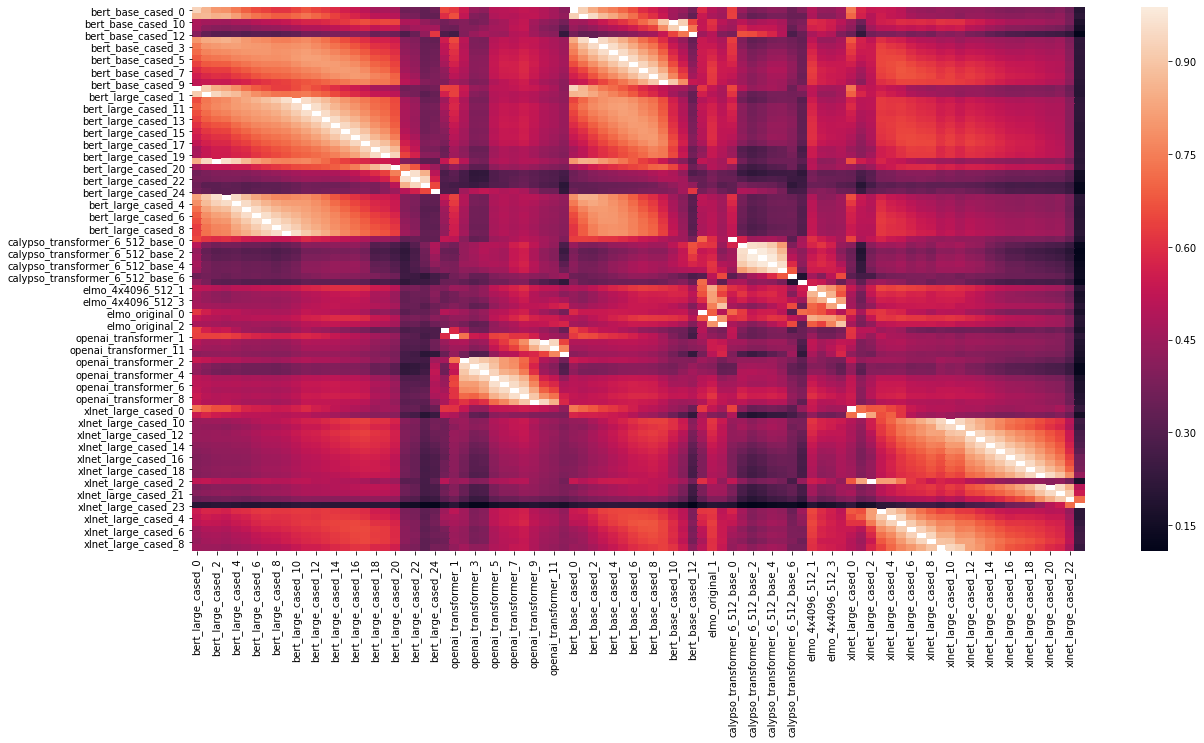

In [18]:
# lincka
sns.heatmap(lincka_df)

In [19]:
# comparing models
# use lincka
model1 = "bert_base_cased"
model2 = "bert_large"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

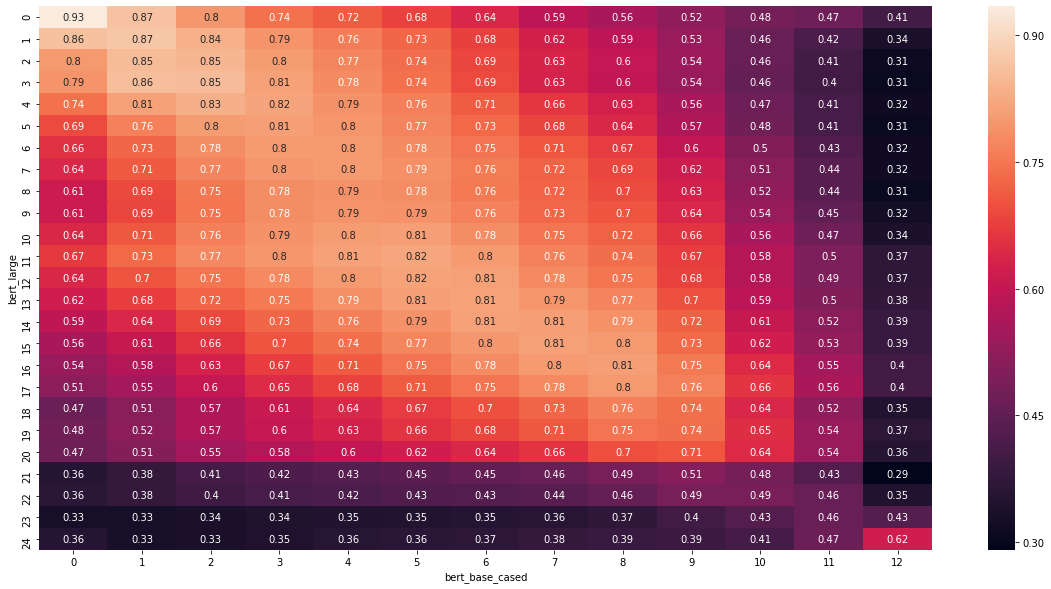

In [20]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()